In [1]:
#""""
# Calculate the rotation angle of morpholgy
# Plot morphology before and after ratation
# Save cell information for bmtk simulations: information includes cell id, layer, creline, e/i, rotation angle etc.
# Yina Wei,created on Feb 21,2019
#""""
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import csv

from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.api.queries.cell_types_api import CellTypesApi
ct = CellTypesApi()

import morph_func as mf

def simpleaxis(ax):
    #Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Example to print the rotation angles for specific cell_id 

In [2]:
cell_list = [485931158,572609108]


for k in range(0,len(cell_list)):
    cell_id = cell_list[k]
    theta = list(np.around(mf.get_rotation_theta(cell_id),decimals=6))
    print cell_id
    print theta

485931158
[-0.059809, 0.0, -1.959499]
572609108
[-0.001946, 0.0, 1.998291]


# Example to plot the morphlogy before and after rotation

485931158
[-0.059809, 0.0, -1.959499]
572609108
[-0.001946, 0.0, 1.998291]


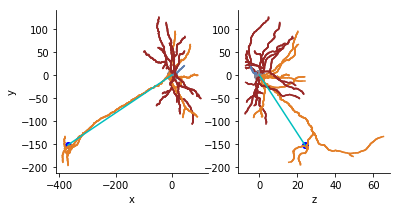

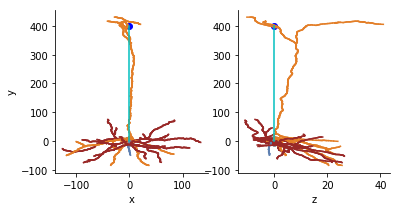

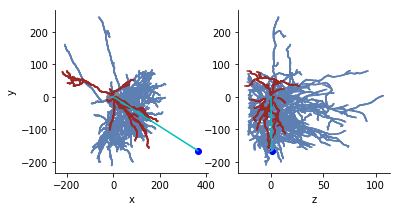

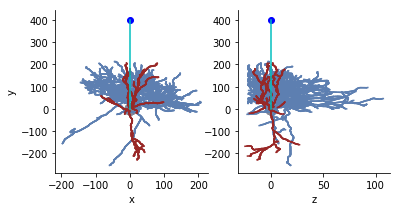

In [3]:
#cell_list = [485931158,572609108]
for k in range(0,len(cell_list)):
    cell_id = cell_list[k]
    # get the morphology data (from apical dendrite, dendrite, and soma) used for PCA
    [morph_data,morph_soma]=mf.get_cell_morphXYZ(cell_id)
    #print(morph_data.shape)
    
    # get the first principal vector and the rotation angle
    [v,theta] = mf.cal_rotation_angle(morph_data)

    # Based on the rotation angle to calculate the rotation matrix R
    R = mf.eulerAnglesToRotationMatrix(theta)  # rotation matrix

    # the first principal component before and after rotated   
    v = v*400
    v_rot = R.dot(v)   
    # The morphology locations used for PCA after rotations
    X_rot = np.array(morph_data)    # The rotated position of new x,y,z
    for i in range(0,len(X_rot)):
        X_rot[i,:]=R.dot(morph_data[i,:])
    
    print(cell_id)
    print list(np.around(theta,decimals=6))
    
    # The location of soma, defined by the user
    x_soma=0
    y_soma=0
    z_soma=0
    # The original morphology before rotations
    theta0=[0,0,0]
    morph0 = mf.cell_morphology_rot(cell_id,x_soma,y_soma,z_soma,theta0)

    # Plot the morphology in xy and zy axis
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    mf.plot_cell_morph_xyzy(axes,morph0)
    # plot the principal vectors on top of the morphology
    axes[0].plot([x_soma,v[0]], [y_soma,v[1]], color='c')
    axes[1].plot([x_soma,v[2]], [y_soma,v[1]], color='c')
    axes[0].scatter(v[0],v[1],color='blue')
    axes[1].scatter(v[2],v[1],color='blue')
    # save the figure
    #fig.savefig('Rotation/'+str(cell_id)+'.png',bbox_inches = 'tight')

    # The morphology after rotations
    morph_rot = mf.cell_morphology_rot(cell_id,x_soma,y_soma,z_soma,theta)

    # Plot the morphology in xy and zy axis
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    mf.plot_cell_morph_xyzy(axes,morph_rot)
    # plot the principal vectors on top of the morphology
    axes[0].plot([x_soma,v_rot[0]], [y_soma,v_rot[1]], color='c')
    axes[1].plot([x_soma,v_rot[2]], [y_soma,v_rot[1]], color='c')
    axes[0].scatter(v_rot[0],v_rot[1],color='blue')
    axes[1].scatter(v_rot[2],v_rot[1],color='blue')

# Example to save the information of each cell_id for further simulation

In [4]:
#cell_list = [485931158,572609108]
with open('celltypes_table.csv', 'w') as csvfile:
    fieldnames = ['specimen__id', 'layer','Cre_line','ei','theta_x','theta_y','theta_z']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for k in range(0,len(cell_list)):
        cell_id = cell_list[k]
        info = ct.get_cell(cell_id)
        if info['tag__dendrite_type']=='aspiny':
            eitype = 'i'
        else:
            eitype = 'e'
        theta = list(np.around(mf.get_rotation_theta(cell_id),decimals=6))
        theta[2]=-theta[2] # because in bmtk, using -theta_z
        writer.writerow({'specimen__id': info['specimen__id'], 'layer':'L'+info['structure__layer'] , 'Cre_line': info['line_name'].split('-')[0],'ei':eitype,'theta_x':theta[0],'theta_y':theta[1],'theta_z':theta[2]})